In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit

from workflow.tools.models import *
from workflow.tools.metrics import *
from workflow.tools.conversion import *

class NNPortfolioOptimizer:

    def __init__(
            self, 
            prices, 
            nn="lstm", 
            lookback=50, 
            n_periods=252, 
            lookahead=2, 
            log=True, 
            hidden_dim=64, 
            random_state=42
    ):

        torch.manual_seed(random_state)

        # PARAMS ------------------------------------------------
        self._lookback = lookback
        self._lookahead = n_periods * lookahead
        
        # OPTIMIZATION ------------------------------------------
        self._model = LSTMPortfolioOptimizer if nn == "lstm" \
            else CNNPortfolioOptimizer if nn == "cnn" \
                else AttentionLSTMPortfolioOptimizer
        
        self.optimizations = {
            "MAX_SHARPE": {
                "OBJ": neg_sharpe_ratio,
                "WEIGHTS": [],
                "RETURNS": None
            }
        }

        self.optimized_returns = None

        # DATA --------------------------------------------------
        self._prices = prices
        self._returns = np.log(prices).diff()[1:] if log else prices.pct_change()[1:]
        self._returns.columns = [f"{col}_RET" for col in self._returns.columns]
        self._data = pd.concat([self._prices, self._returns], axis=1).dropna()
        self._X, self._y = self._get_X_and_y(self._data, self._lookback)
        self._input_size = self._get_size(self._X)
        self._hidden_dim = hidden_dim
        self._output_size = self._get_size(self._y)
        self._tss = TimeSeriesSplit(test_size=self._lookahead)

        self.model = self._init_model(self._model, self._input_size, self._hidden_dim, self._output_size)
        self.optimizer = self._init_optim(self.model)

    def optimize(self, val_size=0.2, epochs=100):

        self.optimizations = self._fit_predict(
            self.model, self.optimizer, self.optimizations, self._X, self._y, self._tss, val_size, epochs
        )
        
        self.optimized_returns = self._backtest(self.optimizations, self._data, self._prices, self._returns)
    
    def _get_X_and_y(self, data, lookback):
        return_cols = [col for col in data.columns if "RET" in col]
        n_samples = len(data) - lookback
        n_features = len(data.columns)
        X = np.zeros((n_samples, lookback, n_features))
        y = data[return_cols].iloc[lookback:].values
        for i in range(lookback, len(data)):
            X[i-lookback] = data.iloc[i-lookback:i]
        return X, y

    def _get_size(self, D):
        return D.shape[-1]

    def _train_test_split(self, X, y, train_idx, test_idx, val_size):
        val_start = int(len(train_idx) * (1 - val_size))
        X_train, X_val, X_test = X[:val_start], X[val_start:], X[test_idx]
        y_train, y_val, y_test = y[:val_start], y[val_start:], y[test_idx]
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def _to_tensors(self, *arrays):
        tensors = []
        for array in arrays:
            tensors.append(torch.tensor(array, dtype=torch.float32))
        return tuple(tensors)

    def _split_data(self, X, y, train_idx, test_idx, val_size):
        X_train, X_val, X_test, y_train, y_val, y_test = self._train_test_split(
            X, y, train_idx, test_idx, val_size
        )
        return self._to_tensors(X_train, X_val, X_test, y_train, y_val, y_test)

    def _init_model(self, model, i, h, o):
        return model(i, h, o)

    def _init_optim(self, model):
        return torch.optim.Adam(model.parameters())
    
    def _validate(self, model, X, y, params):
        with torch.no_grad():
            allocations = model(X)
            obj = params["OBJ"](allocations, y)
        return obj

    def _fit(self, model, optimizer, epochs, X_train, y_train, X_val, y_val, params, e):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = self.model(X_train)
            obj = params["OBJ"](outputs, y_train)
            obj.backward()
            optimizer.step()

            val_loss = self._validate(model, X_val, y_val, params)
            self._print_training_loop(epoch, epochs, obj, val_loss, e)

        print()
    
    def _print_training_loop(self, epoch, epochs, obj, val_obj, e):
        print(
            f"Split {e+1}: Epoch {epoch+1}/{epochs} ({(epoch+1)/epochs*100:,.2f}%)",
            "|",
            f"Train: {obj.item():,.5f}", 
            f"Val: {val_obj.item():,.5f}" ,
            end="\r"
        )
    
    def _predict(self, model, X):
        with torch.no_grad():
            model_allocations = model(X)
        return model_allocations

    def _net_tc(self, returns: pd.Series, weights: pd.DataFrame, cost_rate: float=0.005) -> pd.Series:
        delta_weights = weights.diff().abs().sum(axis=1)
        tc = delta_weights * cost_rate
        returns = returns - tc
        return returns
    
    def _backtest(self, optimizations, data, prices, returns):
        optimized_returns = []

        for opt_type, params in optimizations.items():
            weights = np.concatenate(params["WEIGHTS"])
            reindexed_data = data.iloc[-len(weights):]
            weights = pd.DataFrame(weights, index=reindexed_data.index, columns=prices.columns)
            weights = weights.shift()[1:]
            reindexed_returns = reindexed_data[returns.columns][1:]
            reindexed_returns.columns = prices.columns
            returns = (weights * reindexed_returns).sum(axis=1)
            returns = self._net_tc(returns, weights, cost_rate=0.005)
            returns.name = opt_type
            params["WEIGHTS"] = weights
            params["RETURNS"] = returns
            optimized_returns.append(returns)

        optimized_returns = pd.concat(optimized_returns, axis=1)
        optimized_returns.loc[optimized_returns.index.min()] = 0

        return optimized_returns
    
    def _fit_predict(self, model, optimizer, optimizations, X, y, tss, val_size, epochs):
        for i, (opt_type, params) in enumerate(optimizations.items()):
            print(f"-- {i+1}: {opt_type} --", end="\n")
            for e, (train_idx, test_idx) in enumerate(tss.split(X)):
                X_train, X_val, X_test, y_train, y_val, _ = self._split_data(
                    X, y, train_idx, test_idx, val_size
                )
                self._fit(model, optimizer, epochs, X_train, y_train, X_val, y_val, params, e)
                optimizations[opt_type]["WEIGHTS"].append(self._predict(model, X_test))
            print()
        return optimizations

In [19]:
prices = pd.read_csv("workflow/data/index_prices.csv", index_col=0, parse_dates=True)

po = NNPortfolioOptimizer(prices, nn="lstm", lookback=50, n_periods=252, log=True, random_state=8)

po.optimize()

-- 1: MAX_SHARPE --
Split 1: Epoch 100/100 (100.00%) | Train: -2.94823 Val: -0.78025
Split 2: Epoch 100/100 (100.00%) | Train: -3.81852 Val: -0.85654
Split 3: Epoch 100/100 (100.00%) | Train: -3.99218 Val: -0.95602
Split 4: Epoch 100/100 (100.00%) | Train: -3.94478 Val: -0.97240
Split 5: Epoch 100/100 (100.00%) | Train: -4.16692 Val: -1.12724



<Axes: xlabel='Date'>

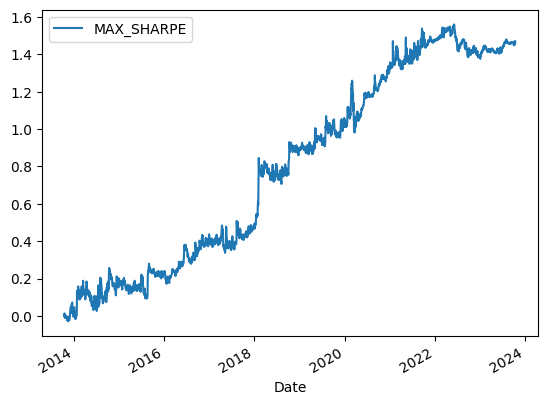

In [21]:
po.optimized_returns.cumsum().plot()